# Analyzing NYC's Stormwater Flood Map - Extreme Flood Scenario
## Objective: Retrieve Hourly and Daily Precipitaton Data

Mark Bauer

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,seaborn,matplotlib,geopandas

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.23.1
pandas    : 1.4.3
seaborn   : 0.11.2
matplotlib: 3.5.2
geopandas : 0.11.1



# 1) Hourly Precipitation Data

##  ASOS Data Download from Iowa Environmental Mesonet (IEM)

Source: https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS#

![iem-cover-photo](images/iem-cover-photo.png)

Screenshot of ASOS-AWOS-METAR Data Download.  

![asos-data-dictionary](images/asos-data-dictionary.png)

Screenshot of ASOS-AWOS-METAR Data Dictionary.

The url below was generated from the website above. Note: data retrieved is in millimeters (mm).

In [3]:
# url of data, this was performed manually by me
url = 'https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?\
station=NYC&data=p01m&year1=1928&month1=1&day1=1&year2=2023&month2=10&day2=9&tz=Etc%2FUTC\
&format=onlycomma&latlon=yes&elev=no&missing=empty&trace=null&direct=no&report_type=3'

df = pd.read_csv(url)
print('shape of data: {}'.format(df.shape))

# preview data
df.head()

shape of data: (309041, 5)


,station,valid,lon,lat,p01m
0,NYC,1943-12-01 05:00,-73.9693,40.779,NaN
1,NYC,1943-12-01 06:00,-73.9693,40.779,NaN
2,NYC,1943-12-01 07:00,-73.9693,40.779,NaN
3,NYC,1943-12-01 08:00,-73.9693,40.779,NaN
4,NYC,1943-12-01 09:00,-73.9693,40.779,NaN


In [4]:
# review column nulls and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309041 entries, 0 to 309040
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   station  309041 non-null  object 
 1   valid    309041 non-null  object 
 2   lon      309041 non-null  float64
 3   lat      309041 non-null  float64
 4   p01m     112502 non-null  float64
dtypes: float64(3), object(2)
memory usage: 11.8+ MB


In [5]:
## to datetime
df['datetime'] = pd.to_datetime(df['valid'])
print('new hourly dtype: {}'.format(df['datetime'].dtype))

## mm to inches, rename mm column name
df['p01in'] = round(df['p01m'] / 25.4, 4)
df = df.rename(columns={'p01m':"p01mm"})

# preview data
df.head()

new hourly dtype: datetime64[ns]


,station,valid,lon,lat,p01mm,datetime,p01in
0,NYC,1943-12-01 05:00,-73.9693,40.779,NaN,1943-12-01 05:00:00,NaN
1,NYC,1943-12-01 06:00,-73.9693,40.779,NaN,1943-12-01 06:00:00,NaN
2,NYC,1943-12-01 07:00,-73.9693,40.779,NaN,1943-12-01 07:00:00,NaN
3,NYC,1943-12-01 08:00,-73.9693,40.779,NaN,1943-12-01 08:00:00,NaN
4,NYC,1943-12-01 09:00,-73.9693,40.779,NaN,1943-12-01 09:00:00,NaN


In [6]:
# review column nulls and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309041 entries, 0 to 309040
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   station   309041 non-null  object        
 1   valid     309041 non-null  object        
 2   lon       309041 non-null  float64       
 3   lat       309041 non-null  float64       
 4   p01mm     112502 non-null  float64       
 5   datetime  309041 non-null  datetime64[ns]
 6   p01in     112502 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 16.5+ MB


In [7]:
# review summary statistics
df.describe()

,lon,lat,p01mm,p01in
count,3.090410e+05,309041.000,112502.000000,112502.000000
mean,-7.396930e+01,40.779,0.349552,0.013760
std,2.842176e-14,0.000,1.499465,0.059034
min,-7.396930e+01,40.779,0.000000,0.000000
25%,-7.396930e+01,40.779,0.000000,0.000000
50%,-7.396930e+01,40.779,0.000000,0.000000
75%,-7.396930e+01,40.779,0.000000,0.000000
max,-7.396930e+01,40.779,80.010000,3.150000


In [8]:
# identify first non-null value by datetime
(df
 .sort_values(by='valid')
 .loc[df['p01mm'].notnull()]
 .head()
)

,station,valid,lon,lat,p01mm,datetime,p01in
5121,NYC,1965-01-02 18:00,-73.9693,40.779,0.51,1965-01-02 18:00:00,0.0201
5122,NYC,1965-01-02 21:00,-73.9693,40.779,1.27,1965-01-02 21:00:00,0.0500
5123,NYC,1965-01-03 00:00,-73.9693,40.779,1.27,1965-01-03 00:00:00,0.0500
5126,NYC,1965-01-03 09:00,-73.9693,40.779,0.25,1965-01-03 09:00:00,0.0098
5167,NYC,1965-01-08 12:00,-73.9693,40.779,2.03,1965-01-08 12:00:00,0.0799


In [9]:
# retrieving data starting at first observation that's non-null
start = (
    df
    .sort_values(by='valid')
    .loc[df['p01mm'].notnull()]
    .head(1)
    .index[0]
)

df = (
    df
    .iloc[start:]
    .reset_index(drop=True)
)

print('new shape of data: {}'.format(df.shape))
df.head()

new shape of data: (303920, 7)


,station,valid,lon,lat,p01mm,datetime,p01in
0,NYC,1965-01-02 18:00,-73.9693,40.779,0.51,1965-01-02 18:00:00,0.0201
1,NYC,1965-01-02 21:00,-73.9693,40.779,1.27,1965-01-02 21:00:00,0.0500
2,NYC,1965-01-03 00:00,-73.9693,40.779,1.27,1965-01-03 00:00:00,0.0500
3,NYC,1965-01-03 03:00,-73.9693,40.779,NaN,1965-01-03 03:00:00,NaN
4,NYC,1965-01-03 06:00,-73.9693,40.779,NaN,1965-01-03 06:00:00,NaN


In [10]:
print('datetime bounds of analysis:\n')
print('date min: {}'.format(df['datetime'].min()))
print('date max: {}'.format(df['datetime'].max()))

datetime bounds of analysis:

date min: 1965-01-02 18:00:00
date max: 2023-10-08 23:51:00


In [11]:
# reaaranging columns and writing our file

cols = ['station', 'valid', 'datetime', 'lon', 'lat', 'p01mm',  'p01in']

(df
 .loc[:, cols]
 .to_csv('data/hourly-precipitation.csv', index=False)
)

# Analysis of extreme rainfall

>The standard design criterion in New York City is to use the
>intensity-duration values based on a storm with a 5-year return
>period (e.g., 1.75 inches per hour for a one hour storm; 20 percent
>chance of occurrence in any given year) to calculate how large the
>sewer pipes need to be sized to appropriately manage stormwater.
>Certain older areas of the City are designed to a 3-year storm
>event. The sewer design flow is then determined by application
>of an equation using a runoff coefficient, a rainfall intensity
>determined from an equation derived from the IDF analysis, and
>the contributory drainage area. The design of combined sewers
>includes allowance for the sanitary flows. The IDF curve currently
>used by New York City is based on historical data from 1903-1951.
>With climate change, the intensity and duration of a storm with a
>5-year return period is likely to increase, and therefore the current
>curve may not be adequate for designing infrastructure that is to
>last decades.

Source: https://www.nyc.gov/assets/orr/pdf/publications/stormwater-resiliency-plan.pdf

In [12]:
# dataframe of hourly precipitation >= 1.75
df.loc[df['p01in'] >= 1.75]

,station,valid,lon,lat,p01mm,datetime,p01in
138032,NYC,2004-09-08 11:51,-73.9693,40.779,44.70,2004-09-08 11:51:00,1.7598
285345,NYC,2021-08-22 03:51,-73.9693,40.779,49.28,2021-08-22 03:51:00,1.9402
285607,NYC,2021-09-02 01:51,-73.9693,40.779,80.01,2021-09-02 01:51:00,3.1500
303694,NYC,2023-09-29 13:51,-73.9693,40.779,49.78,2023-09-29 13:51:00,1.9598


In [13]:
counts = df.loc[df['p01in'] >= 1.75].shape[0]

print('Number of hourly observations with >= 1.75 inches of precipitation: {}'.format(counts))

Number of hourly observations with >= 1.75 inches of precipitation: 4


In [14]:
# records in print view
records = (
    df
    .loc[df['p01in'] >= 1.75, ['valid', 'p01in']]
    .rename(columns={'valid':'date', 'p01in':'inches'})
    .sort_values(by='inches', ascending=False)
    .set_index('date')
)

print(records)

                  inches
date                    
2021-09-02 01:51  3.1500
2023-09-29 13:51  1.9598
2021-08-22 03:51  1.9402
2004-09-08 11:51  1.7598


**Table xx:** Top precipitation events of over 1.75 inches of rainfall per hour at Central Park, NYC.

In [15]:
# top 20 hourly precipitation events
records = (
    df
    .loc[:, ['valid', 'p01in']]
    .rename(columns={'valid':'date', 'p01in':'inches'})
    .sort_values(by='inches', ascending=False)
    .set_index('date')
    .head(20)
)

print(records)

                  inches
date                    
2021-09-02 01:51  3.1500
2023-09-29 13:51  1.9598
2021-08-22 03:51  1.9402
2004-09-08 11:51  1.7598
2005-08-14 23:51  1.7000
2007-08-08 10:51  1.7000
2018-08-11 12:51  1.6598
2020-08-12 20:51  1.6299
1967-07-03 09:00  1.5799
2006-08-10 23:51  1.5701
2021-07-08 21:51  1.5598
1973-08-02 15:00  1.5098
2021-09-02 02:51  1.5000
2010-10-01 09:51  1.4799
2009-01-17 16:51  1.4299
2009-01-17 23:51  1.4098
2021-08-22 02:51  1.3799
2021-07-12 06:51  1.3500
2022-12-23 09:51  1.3299
2009-01-17 21:51  1.3299


**Table xx:** Top 20 precipitation events per hour at Central Park, NYC.

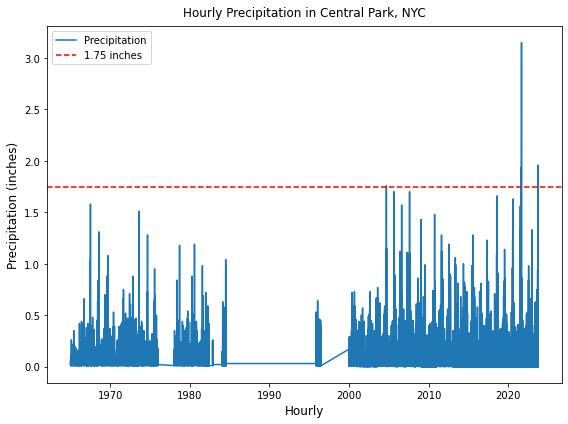

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=df['datetime'],
    y=df['p01in'],
    label='Precipitation'
)

plt.title(
    'Hourly Precipitation in Central Park, NYC', 
    fontsize=12,
    pad=10
)

plt.axhline(y=1.75, color='r',linestyle='--', label='1.75 inches')

plt.legend(loc=2)
plt.xlabel('Hourly', fontsize=12)
plt.ylabel('Precipitation (inches)', fontsize=12)
plt.tight_layout()

**Figure xx:** The figure above looks a bit weird with big chunks of missing data. This is only to demonstrate the distribution of values and extreme values. There is a big gap in the hourly data from 1985 to 2000.

# 2) Daily Precipitation Data

I decided not to use the hourly precipitation data from IEM because of quality control concerns at the 24-hour level. Instead, I used NOAA's NCEI Climate Data Online Daily Summaries.

## NCEI Climate Data Online's Daily Summaries, NY CITY CENTRAL PARK, NY US

Source: https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094728/detail

![ncei-daily-summaries](images/ncei-daily-summaries.png)

Screenshot of NCEI Climate Data Online's Daily Summaries.

In [17]:
# download of data was performed manually by me
df = pd.read_csv('data/daily-precipitation.csv')

## to datetime
df['datetime'] = pd.to_datetime(df['DATE'])
print('new dtype: {}'.format(df['datetime'].dtype))

# preview data
print('shape of data: {}'.format(df.shape))
df.head()

new dtype: datetime64[ns]
shape of data: (56535, 9)


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,datetime
0,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-01,0.75,",,Z,",1869-01-01
1,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-02,0.03,",,Z,null",1869-01-02
2,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-03,0.00,"T,,Z,null",1869-01-03
3,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-04,0.18,",,Z,null",1869-01-04
4,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-05,0.05,",,Z,null",1869-01-05


In [24]:
print('datetime bounds of analysis:\n')
print('date min: {}'.format(df['datetime'].min()))
print('date max: {}'.format(df['datetime'].max()))

datetime bounds of analysis:

date min: 1869-01-01 00:00:00
date max: 2023-10-15 00:00:00


## The number of days with extreme rainfall

>Recent academic studies show that sub-daily rainfall intensity
>may increase over the coming decades.<sup>5</sup> Since rainfall information
>started being collected, the number of days with extreme rainfall
>(defined as days of rainfall over 1.75 inches in Central Park) has
>increased.<sup>6</sup>

Source: https://www.nyc.gov/assets/orr/pdf/publications/stormwater-resiliency-plan.pdf

In [19]:
counts = df.loc[df['PRCP'] >= 1.75].shape[0]

print('Total number of daily observations with >= 1.75 inches of precipitation: {}'.format(counts))

Total number of daily observations with >= 1.75 inches of precipitation: 545


In [20]:
# top 20 daily precipitation events
records = (
    df
    .loc[:, ['datetime', 'PRCP']]
    .rename(columns={'datetime':'date', 'PRCP':'inches'})
    .sort_values(by='inches', ascending=False)
    .set_index('date')
    .head(20)
)

print(records)

            inches
date              
1882-09-23    8.28
2007-04-15    7.57
1977-11-08    7.40
1903-10-09    7.33
2021-09-01    7.13
2011-08-14    5.81
1972-11-08    5.60
1966-09-21    5.54
2023-09-29    5.48
1999-09-16    5.02
1913-10-01    4.98
2014-04-30    4.97
1934-09-08    4.86
1909-08-16    4.80
1873-08-20    4.80
1990-08-10    4.64
2021-08-21    4.45
1996-10-19    4.35
1983-04-10    4.31
1903-10-08    4.30


**Table xx:** Top precipitation events per day at Central Park, NYC.

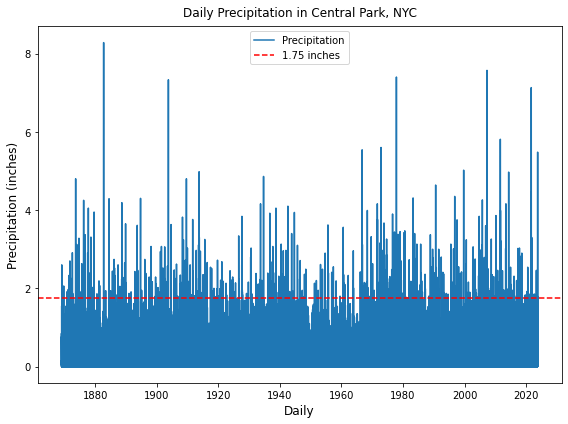

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=df.set_index('datetime').index,
    y=df['PRCP'],
    label='Precipitation'
)

plt.title(
    'Daily Precipitation in Central Park, NYC', 
    fontsize=12,
    pad=10
)

plt.axhline(y=1.75, color='r', linestyle='--', label='1.75 inches')

plt.legend(loc='upper center')
plt.xlabel('Daily', fontsize=12)
plt.ylabel('Precipitation (inches)', fontsize=12)
plt.tight_layout()

**Figure xx:** Daily Precipitation in Central Park, NYC.

In [22]:
# assign flag to extreme days
df.loc[df['PRCP'] >= 1.75, ['threshold']] = 1

# count days and bin data by decade
bins = [x for x in range(1860, 2040, 10)]
df['bins'] = pd.cut(df['datetime'].dt.year, bins=bins)

data = (
    df
    .groupby(by='bins')['threshold']
    .sum()
    .astype(int)
    .rename('count')
    .reset_index()
)

# clipping incomplete decades, remove from plot
data = data.iloc[1:-1, :]
data

,bins,count
1,"(1870, 1880]",33
2,"(1880, 1890]",30
3,"(1890, 1900]",26
4,"(1900, 1910]",41
5,"(1910, 1920]",36
6,"(1920, 1930]",27
7,"(1930, 1940]",32
8,"(1940, 1950]",21
9,"(1950, 1960]",22
10,"(1960, 1970]",25


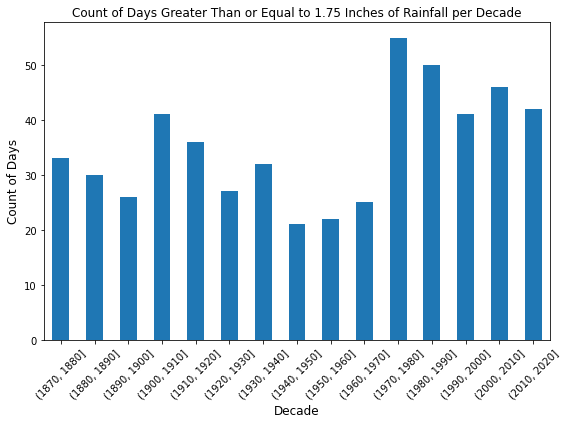

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

data.plot.bar(
    x='bins',
    y='count',
    rot=45,
    legend=None,
    ax=ax 
)

plt.title('Count of Days Greater Than or Equal to 1.75 Inches of Rainfall per Decade', fontsize=12)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Count of Days', fontsize=12)
plt.tight_layout()

**Figure xx:** Count of days greater than or equal to 1.75 inches of rainfall per decade.

# 3) NOAA ATLAS 14 Point Precipitation Frequency Estimates

>NOAA Atlas 14 estimates are used to design, plan, and manage
>much of the Nation's infrastructure for a wide variety of purposes
>under federal, state, and local regulations. NOAA Atlas 14
>estimates replace estimates previously published by NOAA in
>the early 1960s and '70s and cover a range of storm durations
>from 5-minutes through 60-days, for average recurrence intervals
>of 1-year through 1,000-year. Compared to previous volumes,
>Atlas 14 estimates benefit from use of better-quality data (e.g.
>precipitation stations with longer period of record, increased
>station density, etc.), enhanced quality control methods,
>consideration of uncertainties, and improved frequency analysis
>and spatial interpolation methods that account for variation in
>terrain, proximity to the coastline etc.

Source: https://www.weather.gov/owp/hdsc

Atlas 14 is so influencial with the country's design standards, I figured I would add a section about it. The first set of screen shots are from NOAA's Atlas 14, and the last ones are the flood scenarios from the NYC Stormwater Flood Maps. It's good to understand the relationship between duration (e.g. 60-min), average reoccurance interval (100-year), and potential flood depth (e.g. )

## Station Name: NY CITY CNTRL PARK
Below are screen shots and data for Central Park, NYC.

![atlas-14-cover](images/atlas-14-cover.png)

Screenshot of the landing page.  
Source: https://hdsc.nws.noaa.gov/pfds/pfds_map_cont.html?bkmrk=ny

![frequency-table](images/frequency-table.png)

Table caption from NOAA:  
>Precipitation frequency (PF) estimates in this table are based on frequency analysis of partial duration 
>series (PDS). Numbers in parenthesis are PF estimates at lower and upper bounds of the 90% confidence interval.
>The probability that precipitation frequency estimates (for a given duration and average recurrence interval)
>will be greater than the upper bound (or less than the lower bound) is 5%.
>Estimates at upper bounds are not checked against probable maximum precipitation (PMP) estimates and may be higher than currently valid PMP  values. Please refer to NOAA Atlas 14 document for more information.

Source: https://hdsc.nws.noaa.gov/pfds/pfds_printpage.html?st=ny&sta=30-5801&data=depth&units=english&series=pds

![ddf-curves](images/ddf-curves.png)

Source: https://hdsc.nws.noaa.gov/pfds/pfds_printpage.html?st=ny&sta=30-5801&data=depth&units=english&series=pds

The flood scenarios for the NYC Stormwater Flood Maps are as follows:

![iem-cover-photo](images/flood-scenarios.png)
  
Source: https://experience.arcgis.com/experience/6f4cc60710dc433585790cd2b4b5dd0e